In [1]:
import re
import matplotlib.pyplot as plt
import numpy as np
import scipy.sparse as sp
from glob import glob
import matplotlib.patches as patches
import pandas as pd
import math
# import bcolz
import time
import os
import cmath
from scipy.sparse.linalg import bicgstab
from scipy import sparse
import numpy.matlib
from scipy.stats import norm

In [2]:
def fully_connected_e_neighbour_graph(img, sigma, e):
    array = np.array(img)
    rowN = np.shape(array)[0]
    colN = np.shape(array)[1]
    result = np.zeros((rowN * colN, rowN * colN))
    for row in range(rowN):
        for col in range(colN):
            for rowDiff in range(-e, e + 1, 1):
                for colDiff in range(-e, e + 1, 1):
                    # Avoid self edges
                    if rowDiff == 0 and colDiff == 0:
                        continue
                    if (row + rowDiff < rowN and -1 < row + rowDiff and col + colDiff < colN and -1 < col + colDiff):
                        if (rowDiff * rowDiff + colDiff * colDiff <= e * e):
                            row2 = row + rowDiff
                            col2 = col + colDiff
                            weight = math.exp(- math.pow(img[row][col] - img[row2][col2], 2) / (2 * math.pow(sigma, 2)))
                            result[row * colN + col][row2 * colN + col2] = weight
    # Convert it to sparse matrix
    # TODO: Direct initialization as sparse matrix is better
    return sp.csc_matrix(result)


def laplacian(graph):
    # diag = np.diag(sum(graph))
    diag = sp.diags((sum(graph)).toarray()[0], 0)
    lap = diag - graph
    return [lap, diag]


def makeChessBoard(WhiteFrameWidth, chessNodeWidth, chessElementNumberPerRow):
    size = WhiteFrameWidth * 2 + chessElementNumberPerRow * chessNodeWidth
    A = np.zeros((size, size))
    for i in range(size - 2 * WhiteFrameWidth):
        for j in range(size - 2 * WhiteFrameWidth):
            if ((int(i / chessNodeWidth)) + (int(j / chessNodeWidth))) % 2 == 0:
                A[WhiteFrameWidth + i][WhiteFrameWidth + j] = 200
    return A


def makeGrid(img):
    row = img.shape[0]
    col = img.shape[1]
    A = np.zeros((row * col, row * col))
    for i in range(row):
        for j in range(col):
            if j != col - 1:
                A[i * col + j, i * col + (j + 1)] = 1
            if j != 0:
                A[i * col + j, i * col + (j - 1)] = 1
            if i != row - 1:
                A[(i + 1) * col + j, i * col + j] = 1
            if i != 0:
                A[(i - 1) * col + j, i * col + j] = 1
    return sp.csc_matrix(A)


def starOpt_fast(A, c, gamma, s, k, max_iter):

    n = A.shape[0]
    A = sp.csc_matrix(A)

    [coords_i, coords_j, V] = sp.find(A)
    [tri_i, tri_j, V] = sp.find(sp.triu(A))

    mapping = triuToFullIdx(coords_i, coords_j, tri_i, tri_j, A)

    degs = sp.csc_matrix(np.transpose(sp.csc_matrix.sum(A, 0)))

    eta = 5
    p = 2 * (np.dot(np.transpose(c), c)) / gamma

    startTime = time.time()
    np.random.seed(2)
    temp = np.transpose(norm.ppf(np.random.rand(k, n)))
    y = temp.copy()
    # y = np.random.normal(0, 1, (n, k))

    normalisation = p / sp.coo_matrix.sum(sp.csc_matrix.multiply(degs, np.sum(np.square(y), axis=1).reshape((y.shape[0], 1))))
    y = y * pow(normalisation[0][0], .5)
    # y = temp.copy() * pow(normalisation[0][0], .5)

    u_s = np.zeros((n, max_iter))
    grad = sp.csc_matrix(np.zeros((n, n)))

    for i in range(max_iter):
        print('Iteration: ' + str(i+1))
        # if (i %  10 == 9):
        #    print("Iteration: " + str(i+1))
        print('a')
        ydist = precomputeDists(tri_i, tri_j, mapping, y)
        print('b')
        mtxop = lambda x: cc_P_gamma_Y_mult(coords_i, coords_j, degs, c, y, gamma, s, x, ydist)
        LO = sp.linalg.LinearOperator((n, n), matvec=mtxop)

        if i == 0:
            [vals, u] = sp.linalg.eigsh(LO, k=1, ncv=5, which='LA', maxiter=100, tol=1 / n)
        else:
            [vals, u] = sp.linalg.eigsh(LO, k=1, ncv=5, which='LA', v0=u_s[:, i - 1], maxiter=100, tol=1 / n)

        u_s[:, i] = u[:, 0]

        QX = Q_gamma_M(A, u, gamma, s)

        # MWU for dual variable Y
        grad = grad - QX
        temp = np.transpose(norm.ppf(np.random.rand(k, n)))
        # y = sp.linalg.expm_multiply(eta/2 * grad, np.random.normal(0, 1, (n, k)) / pow(k, .5))
        y = sp.linalg.expm_multiply(eta / 2 * grad, temp.copy() / pow(k, .5))

        # normalize such that y*y' has degree weighted trace p

        normalisation = p / sp.coo_matrix.sum(sp.csc_matrix.multiply(degs, np.sum(np.square(y), axis=1).reshape((y.shape[0], 1))))
        y = y * pow(normalisation[0][0], .5)
        print('f')


    runningTime = (time.time() - startTime)
    print('Running time of this part is ' + str(runningTime) + ' seconds')
    return u_s


def triuToFullIdx(coords_i, coords_j, tri_i, tri_j, A):
    # Map each edge in graph to the one in sp.triu(A)
    n = A.shape[0]
    mapping = np.zeros((coords_i.shape[0], 1), dtype=int)
    triIdx = {}
    for i in range(len(tri_i)):
        triIdx[tri_i[i] * n + tri_j[i]] = i

    for i in range(len(coords_i)):
        if coords_i[i] < coords_j[i]:
            mapping[i] = triIdx[coords_i[i] * n + coords_j[i]]
        else:
            mapping[i] = triIdx[coords_j[i] * n + coords_i[i]]
    return mapping[:, 0]


def precomputeDists(tri_i, tri_j, mapping, y):
    m = len(tri_i)
    ydist = np.zeros((m, 1))
    for ind in range(m):
        ii = tri_i[ind]
        jj = tri_j[ind]
        ydist[ind] = sum((y[ii, :] - y[jj, :]) ** 2)
    ydist = ydist[mapping, :]

    return ydist


def cc_P_gamma_Y_mult(coords_i, coords_j, degs, c, y, gamma, r, x, ydist):
    n = degs.shape[0]
    if not (len(x) == n and y.shape[0] == n):
        print('Error in parameters... cc_P_gamma_Y_mult')
        return

    # np.random.seed(4)
    # x = norm.ppf(np.random.rand(n, 1))

    zz = np.multiply(ydist, x[coords_j].reshape(ydist.shape))

    vv = np.zeros((n, 1))

    for i in range(len(coords_i)):
        vv[coords_i[i]][0] = vv[coords_i[i]][0] + zz[i]

    repmatArr = np.matlib.repmat(y[r, :], n, 1) - y
    elWiseMult = np.multiply(repmatArr, repmatArr)
    sumRepmat = np.sum(elWiseMult, axis=1)
    sumRepmat = sumRepmat.reshape(len(sumRepmat), 1)
    x = x.reshape(len(x), 1)
    v = np.dot(np.transpose(c), x) * c + vv - gamma * (sp.csc_matrix.multiply(sp.csc_matrix.multiply(degs, x), sumRepmat))
    return v


def Q_gamma_M(Adj, u, gamma, r):
    n = Adj.shape[0]
    degs = sp.csc_matrix(np.transpose(sp.csc_matrix.sum(Adj, axis=0)))

    #np.random.seed(4)
    #u = norm.ppf(np.random.rand(n, 1))

    [coords_i, coords_j, V] = sp.find(sp.triu(Adj))
    xvals = np.zeros((len(coords_i), 1))
    dvals = np.zeros((n, 1))

    for c in range(len(coords_i)):
        ii = coords_i[c]
        jj = coords_j[c]
        xvals[c][0] = -u[ii] * u[jj]
        dvals[ii][0] = dvals[ii][0] + u[jj] / 2
        dvals[jj][0] = dvals[jj][0] + u[ii] / 2

    dvals = np.multiply(dvals, u)
    Q = sp.csc_matrix((np.concatenate((xvals[:, 0], dvals[:, 0])), (
        np.concatenate((coords_i, np.array(range(n)))), np.concatenate((coords_j, np.array(range(n)))))))
    Q = Q + sp.csc_matrix.transpose(Q)
    dX = sp.csc_matrix.multiply(degs, sp.csc_matrix(np.square(u)))
    starX = sp.diags(dX.toarray()[:, 0]).tolil()
    starX[r, :] = -sp.csc_matrix.transpose(dX)
    starX[:, r] = -dX
    starX[r, r] = np.array(sp.csc_matrix.sum(dX, 0))[0][0] - degs.toarray()[r - 1][0] * (u[r - 1][0] * u[r - 1][0])
    Q = Q - gamma * starX
    return Q


In [3]:
img = makeChessBoard(20, 10, 3)
A = makeGrid(img)
sigma = 5
e = 2
graph = fully_connected_e_neighbour_graph(img, sigma, e)
[L, D] = laplacian(graph)
max_iter = 50
inverse = sp.linalg.inv(10 * L + sp.csc_matrix(np.identity(graph.shape[0])))
np.random.seed(1)
# proj1 = np.random.normal(0,1,(A.shape[0],1))
proj1 = norm.ppf(np.random.rand(A.shape[0], 1))
c = inverse.dot(proj1)
gamma = 1
s = 4050
s = s - 1 # Python index starts from 0!
k = 3
c = (sp.linalg.inv(D)).dot(c)

u_s = starOpt_fast(A, c, gamma, s, k, max_iter)

# proj2 = np.random.normal(0, 1, (max_iter, 1))
np.random.seed(3)
proj2 = norm.ppf(np.random.rand(max_iter, 1))
v = np.dot(u_s, proj2)
sizeSqrt = int(pow(v.shape[0], .5))
r = v.reshape((sizeSqrt, sizeSqrt))

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:295: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:202: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  'is in the CSC matrix format', SparseEfficiencyWarning)
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:133: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  SparseEfficiencyWarning)


Iteration: 1
a
b
f
Iteration: 2
a
b
f
Iteration: 3
a
b
f
Iteration: 4
a
b
f
Iteration: 5
a
b
f
Iteration: 6
a
b
f
Iteration: 7
a
b
f
Iteration: 8
a
b
f
Iteration: 9
a
b
f
Iteration: 10
a
b
f
Iteration: 11
a
b
f
Iteration: 12
a
b
f
Iteration: 13
a
b
f
Iteration: 14
a
b
f
Iteration: 15
a
b
f
Iteration: 16
a
b
f
Iteration: 17
a
b
f
Iteration: 18
a
b
f
Iteration: 19
a
b
f
Iteration: 20
a
b
f
Iteration: 21
a
b
f
Iteration: 22
a
b
f
Iteration: 23
a
b
f
Iteration: 24
a
b
f
Iteration: 25
a
b
f
Iteration: 26
a
b
f
Iteration: 27
a
b
f
Iteration: 28
a
b
f
Iteration: 29
a
b
f
Iteration: 30
a
b
f
Iteration: 31
a
b
f
Iteration: 32
a
b
f
Iteration: 33
a
b
f
Iteration: 34
a
b
f
Iteration: 35
a
b
f
Iteration: 36
a
b
f
Iteration: 37
a
b
f
Iteration: 38
a
b
f
Iteration: 39
a
b
f
Iteration: 40
a
b
f
Iteration: 41
a
b
f
Iteration: 42
a
b
f
Iteration: 43
a
b
f
Iteration: 44
a
b
f
Iteration: 45
a
b


/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel_launcher.py:113: RuntimeWarning: overflow encountered in square


f
Iteration: 46
a
b


/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/numpy/core/_methods.py:32: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims)
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/scipy/sparse/compressed.py:409: RuntimeWarning: overflow encountered in multiply
  data = np.multiply(ret.data, other[ret.row, ret.col])


f
Iteration: 47
a
b
f
Iteration: 48
a
b
f
Iteration: 49
a
b
f
Iteration: 50
a
b
f
Running time of this part is 57.90193295478821 seconds


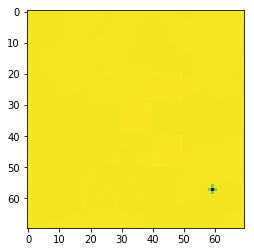

In [7]:
plt.imshow(1e0 * r)
plt.show()